In [1]:
# Covers tabular implementations of SERD and IDL and compares their effectivenes

In [1]:
import numpy as np
from envs import MarsExplorerEnv
import matplotlib.pyplot as plt
import time
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib._png import read_png
import pickle as pkl
%matplotlib inline

import gym
from gym import spaces
from gym.envs.classic_control import rendering
import tensorflow as tf
from scipy.special import logsumexp
from copy import deepcopy as copy
import random
np.set_printoptions(precision=8, suppress=True,threshold=np.nan)

In [2]:
# %store -r

In [3]:
#%store

In [4]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
NOOP = 4

cdict = {'red':   ((0.0,  0.173, 0.173),
                   (1.0,  0.925, 0.925)),

         'green': ((0.0,  0.067, 0.067),
                   (1.0, 0.384, 0.384)),

         'blue':  ((0.0,  0.027, 0.027),
                   (1.0,  0.196, 0.196))}
plt.register_cmap(name='RustPlanet', data=cdict)
REWARD_COLORS = cm.get_cmap('RustPlanet')
AGENT_COLORS = cm.get_cmap('gray')
MAP_COLORS = {b'B':"#3a0e00",
              b'F':"#933111",
              b'S':"#933111",
              b'U':"#d65b33",
              b'1':"#956F52",
              b'2':"#3C2F34",
              b'3':"#644C42"}

ROVER_PNGS = {LEFT:"resources/rover_left.png",
        RIGHT:"resources/rover_right.png",
        DOWN:"resources/rover_down.png",
        UP:"resources/rover_up.png",
        NOOP:"resources/rover_sample.png"}

# tile_map = [
#         "F3FFUFU2U",
#         "FUFUSUFUF",
#         "FFFUSUFFU",
#         "USUUUUUSU",
#         "FFUSSSUFF",
#         "FSFUSUFSF",
#         "UUUUUUUFU",
#         "UFFU1UFUU",
#         "3UUFUFFU1"
#     ]

# tile_map = [
#         "F22222FF1",
#         "U31122FU1",
#         "UF1112FU1",
#         "UFUU1SFU1",
#         "UFFU1FFU3",
#         "3222UFS1U",
#         "UUU22F1FU",
#         "FSSFS12SF",
#         "FSFF121FF",
#         "S1S2SFFSF",
#         "FUUUFFSFU",
#         "U3UUUFSFU",
#         "FFFUUFUUU"
#     ]


tile_map = [
        "2FFFUFFF1",
        "FFFUUUFFF",
        "FFFFUFFFF",
        "FSFUUUFSF",
        "FSUU3UUSF",
        "FSFUUUFSF",
        "FFFFUFFFF",
        "FFFSSSFFF",
        "1FFFFFFF2"
    ]

# tile_map = [
#         "3FFFFFFF1",
#         "FFFFFFFFF",
#         "FFFFUFFFF",
#         "FSFUUUFSF",
#         "FSUU3UUSF",
#         "FSFUUUFSF",
#         "FFFFUFFFF",
#         "FFFSSSFFF",
#         "1FFFFFFF2"
#     ]

tile_rewards = {'F':0.05,
              '1':0.1,
              '2':0.1,
              '3':0.1,
              'S':0.01,
              'U':0.0}


goal_tile_rewards = {'F':0.0,
              '1':1.0,
              '2':2.0,
              '3':4.0,
              'S':0.0,
              'U':0.0}

tile_reward_modifier = lambda r,x,y,mx,my: r * 0.1 * ((x-(mx/2 + np.random.normal(scale=0.5)))**2 + (y - (mx/2 + np.random.normal(scale=0.5)))**2)

def build_reward_map(tile_map, tile_rewards, goal_tile_rewards, tile_reward_modifier):
    reward_map = np.zeros((len(tile_map),len(tile_map[0])))
    texture_map = np.zeros((len(tile_map),len(tile_map[0])))
    for y,row in enumerate(tile_map):
        for x,c in enumerate(row):
            reward_map[y,x] = texture_map[y,x] = tile_reward_modifier(tile_rewards[c],x,y,len(tile_map[0]),len(tile_map))
            reward_map[y,x] +=  goal_tile_rewards[c]
    return reward_map, texture_map

reward_map, texture_map = build_reward_map(tile_map, tile_rewards, goal_tile_rewards, tile_reward_modifier)


t0 = (0.8,0.1,0.0,0.0)
t1 = (0.0,0.0,0.0,1.0)  #(0.1,0.15,0.5,0.1)

trans_dict = {b'F':t0,
              b'1':t0,
              b'2':t0,
              b'3':t0,
              b'S':t0,
              b'U':t1}

#TODO implement theta_mat in mars_explorer so do not need to hard code, use np.roll
true_tps = np.array([[[0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.0, 1.]],

 [[0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.0, 1.]],

 [[0., 0.],
  [0., 0.],
  [0., 0.],
  [0., 0.],
  [1., 1.]]])

gamma = 0.98

alpha = 0.0001

T_theta_shape = (5,5,2)

time_penalty = 0.0


In [5]:
# reward_normalizer = (1-gamma)/(np.max(reward_map))
# reward_map *= reward_normalizer
# time_penalty *= reward_normalizer

In [6]:
# temperature = 1/(reward_normalizer)
# print(temperature)

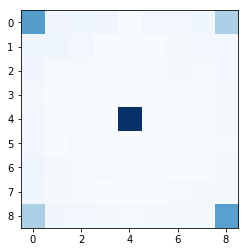

In [7]:
plt.imshow(reward_map, cmap="Blues")

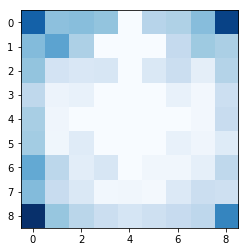

In [8]:
plt.imshow(texture_map, cmap="Blues")

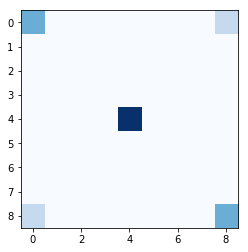

In [9]:
plt.imshow(reward_map - texture_map, cmap="Blues")

In [10]:
mdp = MarsExplorerEnv(tile_map, reward_map, texture_map, trans_dict, time_penalty) 
nA = mdp.num_actions
nS = mdp.num_states

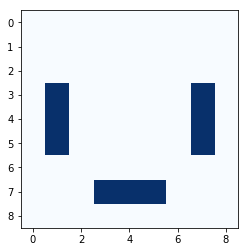

In [11]:
binary_map = np.ones(mdp.tile_map.shape)
binary_map[np.where(mdp.tile_map == b'S')] = 255.0
plt.imshow(binary_map, cmap="Blues")

In [12]:
def plot_mars(mdp, pi, term = 40, title=None, counts = None, Qs = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    s = mdp._reset()
    t, r = 0, 0
    while s is not None and t < term:
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        a = pi[s] if type(pi) == np.ndarray else pi(s)
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}      r: {}'.format(t,round(r,4)), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        if Qs is not None:
            print(Qs[s])
            print(a)
            print(softmax(Qs[s]))
        print(mdp.s_to_grid(s), mdp.tile_map.flatten()[s])
        s, rt, _, d = mdp._step(a)
        print(mdp.s_to_grid(s), mdp.tile_map.flatten()[s])
        t += 1
        r += rt
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

def plot_mars_history(mdp, hist, title=None, counts = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    t = 0
    for s,a,sprime in [h[0] for h in hist]:
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}'.format(t), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        t += 1
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

def plot_values(mdp, Qs, s=None, title=None):
    V = np.max(Qs, axis=1).reshape((mdp.nrow,mdp.ncol))
    pi = np.argmax(Qs, axis=1)
    plt.figure(figsize=(8,8))
    if title != None:
        plt.title(title)
    plt.imshow(V, cmap='gray')#, clim=(0,1)) 'gist_ncar'
    ax = plt.gca()
    ax.set_xticks(np.arange(V.shape[1])-.5)
    ax.set_yticks(np.arange(V.shape[0])-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:V.shape[0], 0:V.shape[1]]
    a2uv = {0: (-1, 0), 1:(0, -1), 2:(1,0), 3:(0, 1), 4:(-1,-1)}
    Pi = pi.reshape(V.shape)
    for y in range(V.shape[0]):
        for x in range(V.shape[1]):
            a = Pi[y, x]
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.2, head_length=0.1) 
            plt.text(x, y, str(mdp.tile_map[y,x].item().decode()),
                     color='c', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
    if s != None:
        plt.plot(s%V.shape[0], s//V.shape[0], 'ro')
#     plt.grid(color='b', lw=2, ls='-')
    return

# Soft-Q Learning

In [13]:
def softmax(x, axis=1):
    """Compute softmax values for each sets of scores in x."""
    axis = 0 if len(x.shape) == 1 else axis
    e_x = np.exp(x - np.max(x, axis=axis,keepdims=True))
    return (e_x / e_x.sum(axis=axis, keepdims = True))

In [14]:
def tabsoftq_iter(R, T, maxiter=10000, verbose=False, Q_init=None, learning_rate=0.5, ftol=1e-32):
    Q = np.zeros((nS, nA)) if Q_init is None else copy(Q_init)
    prevQ = copy(Q)
    if verbose:
        diffs = []
        meanVs = []
    for iter_idx in range(maxiter):
        V = alpha * logsumexp(prevQ / alpha, axis=1)
        V_broad = V.reshape((1, 1, nS))
        Q = np.sum(T * (R + gamma * V_broad), axis=2)
        Q = (1 - learning_rate) * prevQ + learning_rate * Q
        diff = np.mean((Q - prevQ)**2)/(np.std(Q)**2)
        if verbose:
            diffs.append(diff)
            meanVs.append(np.mean(V)) 
        if diff < ftol:
            break
        prevQ = copy(Q)
    if verbose:
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Squared Bellman Error')
        plt.title('Soft Q Iteration')
        plt.plot(diffs)
        plt.yscale('log')
        plt.show()
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Value of All Tiles')
        plt.title('Soft Q Iteration')
        plt.plot(meanVs)
        plt.show()
    return Q

In [15]:
def tabsoftq_learn_Qs(mdp):
    R = mdp.rewards
    T = mdp.get_transition_matrix()
    Qs = tabsoftq_iter(R, T)
    return Qs

def tabsoftq_gen_pol(Qs, beta=1):
    softQs = softmax(Qs * beta)
    return lambda s: np.random.choice(np.asarray(range(len(Qs[s]))),p=softQs[s])

def tabsoftq_gen_pol_probs(Qs, beta=1):
    softQs = softmax(Qs * beta)
    return softQs


In [16]:
def generate_demonstrations(mdp, pol, n, term):
    hists = []
    for i in range(n):
        s, d, t = mdp._reset(), False, 0
        hist = []
        while not d and t < term:
            a = pol[s] if type(pol) == np.ndarray else pol(s)
            sprime, rt, _, ob_dict = mdp._step(a)
            hist += [((s,a,sprime),ob_dict['adt'])]
            t += 1
            s = sprime
        hists += [hist]
    return hists

In [17]:
def tabsoftq_T_grad_iter(T_thetas, Q, R, T=None, maxiter=1000, verbose=True,
                       learning_rate=1, G_init=None, ftol=0):
    
    T_theta_dim = T_thetas.shape[0] * T_thetas.shape[1] * T_thetas.shape[2]
    D = T_thetas.shape[1]
    
    P_broad = tabsoftq_gen_pol_probs(Q).reshape((nS, nA, 1))
    Tps = softmax(T_thetas,axis=1)
    
    if T is None:
        T = mdp.adt_trans_to_sas_trans(Tps)
        
    V = (alpha) * logsumexp(Q * (1 / alpha), axis=1)
    
    T_grad = np.zeros((nS,nA,T_theta_dim))
    for s in range(nS):
        t = mdp.get_tile_type(s)
        for a in range(nA):
            P_at = Tps[a,:,t]
            V_theta = np.array([V[mdp.sd_to_sprime(s,d)] for d in range(D)])
            R_theta = np.array([R[mdp.sd_to_sprime(s,d)] for d in range(D)])
            VR_theta = R_theta + gamma * V_theta 
            D_probs = np.stack([P_at for _ in range(D)])
            grad_at = np.dot((np.eye(D) - D_probs), VR_theta)
            grad_at = np.dot(np.diag(P_at),grad_at)
            filler = np.zeros(T_thetas.shape)
            filler[a,:,t] = grad_at
            filler = filler.flatten()
            T_grad[s,a] = filler
    G = T_grad if G_init is None else G_init
    T_broad = T.reshape((nS, nA, nS, 1))
    prevG = copy(G)
    if verbose:
        diffs = []
    for iter_idx in range(maxiter):
        expG = np.sum(P_broad * G, axis=1)
        expG_broad = expG.reshape((1, 1, nS, T_theta_dim))
        G = gamma * T_grad
        t_expG = np.sum(T_broad * expG_broad, axis=2)
        G += gamma * t_expG
        G = (1 - learning_rate) * prevG + learning_rate * G
    
        diff = np.mean((G - prevG)**2)/(np.std(G)**2)
        if verbose:
            diffs.append(diff)
        if diff < ftol:
            break
        prevG = copy(G)
  
    if verbose:
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Squared Bellman Error')
        plt.title('Soft Q Gradient Iteration')
        plt.plot(diffs)
        plt.yscale('log')
        plt.show()
    expG = np.sum(P_broad * G, axis=1)
    expG_broad = expG.reshape((nS, 1, T_theta_dim))
    return (G - expG_broad)

In [18]:
def vectorize_rollouts(rollouts):
    sas_obs = []
    adt_obs = []
    task_idxes = []
    for rollout in rollouts:
        more_sas, more_adt = list(zip(*rollout))
        sas_obs.extend(more_sas)
        adt_obs.extend(more_adt)
    return np.array(sas_obs), np.array(adt_obs)

Sanity check (env and softq)

/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


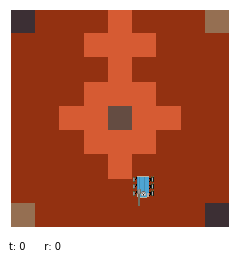

[ 92.41956393 101.09770704 101.72052825  89.98821424  99.69206348]
1
[0.00005476 0.32158743 0.59949681 0.00000481 0.0788562 ]
(5, 7) b'S'
(5, 8) b'F'


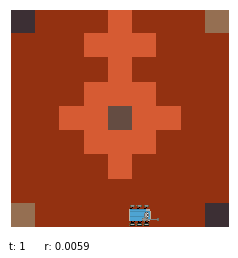

[ 92.94033362  94.44315906 103.98692801  99.5443681  101.97736516]
2
[0.00001391 0.00006252 0.87267602 0.01026771 0.11697983]
(5, 8) b'F'
(6, 8) b'F'


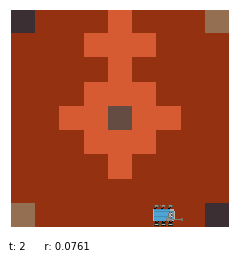

[102.53629146 105.99181965 107.93544126 103.78410857 105.85770805]
2
[0.00350784 0.11111094 0.77599866 0.01221687 0.09716568]
(6, 8) b'F'
(7, 8) b'F'


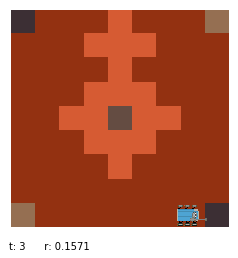

[106.20061725 108.98644095 110.85079536 106.63479324 108.7263024 ]
2
[0.00736052 0.11933737 0.76993721 0.01136237 0.09200252]
(7, 8) b'F'
(8, 8) b'2'


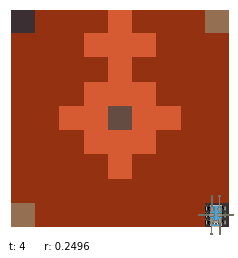

[109.05025183 111.66306274 111.68096027 109.03881457 111.6704307 ]
4
[0.02312259 0.31533047 0.32102491 0.02285964 0.31766239]
(8, 8) b'2'
(8, 8) b'2'


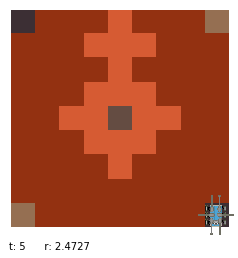

[109.05025183 111.66306274 111.68096027 109.03881457 111.6704307 ]
4
[0.02312259 0.31533047 0.32102491 0.02285964 0.31766239]
(8, 8) b'2'
(8, 8) b'2'


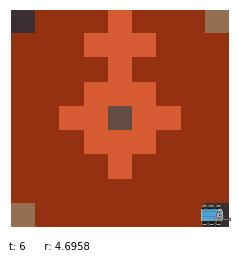

[109.05025183 111.66306274 111.68096027 109.03881457 111.6704307 ]
2
[0.02312259 0.31533047 0.32102491 0.02285964 0.31766239]
(8, 8) b'2'
(0, 8) b'1'


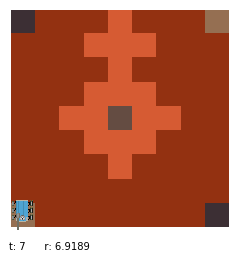

[111.59900639 112.93956966 109.63792628 109.33962724 112.01468796]
1
[0.15193596 0.58057699 0.02137836 0.01586444 0.23024425]
(0, 8) b'1'
(0, 0) b'2'


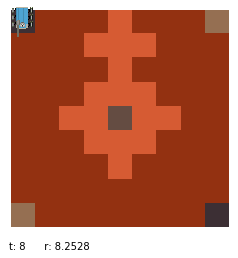

[111.83597674 110.60802766 110.60743895 111.85542407 113.56327317]
1
[0.12149672 0.0355855  0.03556455 0.12388263 0.68347061]
(0, 0) b'2'
(0, 1) b'F'


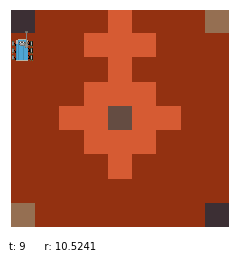

[109.44593558 107.68034593 108.43031603 112.5594586  110.45544245]
3
[0.03734453 0.00638912 0.01352537 0.84025836 0.10248262]
(0, 1) b'F'
(8, 1) b'F'


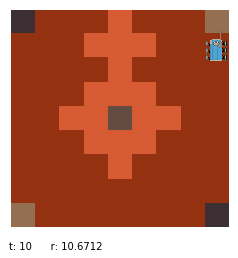

[107.10843014 106.8317863  110.20392882 111.29311486 109.17896254]
3
[0.01026079 0.00778101 0.22674548 0.6738545  0.08135822]
(8, 1) b'F'
(8, 0) b'1'


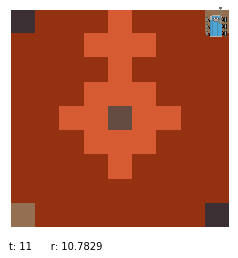

[109.3185664  109.60370074 112.93555786 111.59687526 111.98620463]
3
[0.01569331 0.02087117 0.5841899  0.15316925 0.22607637]
(8, 0) b'1'
(8, 8) b'2'


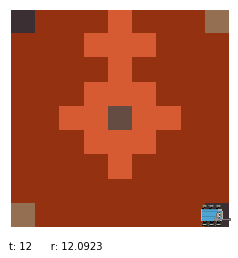

[109.05025183 111.66306274 111.68096027 109.03881457 111.6704307 ]
2
[0.02312259 0.31533047 0.32102491 0.02285964 0.31766239]
(8, 8) b'2'
(8, 7) b'F'


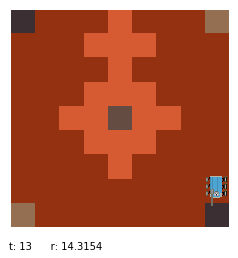

[106.63484022 110.8529265  109.00353697 106.20312421 108.70589442]
1
[0.0113418  0.77014673 0.12116964 0.00736529 0.08997654]
(8, 7) b'F'
(8, 8) b'2'


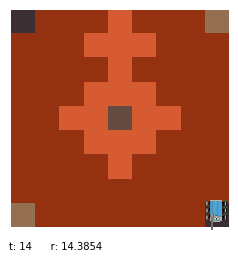

[109.05025183 111.66306274 111.68096027 109.03881457 111.6704307 ]
1
[0.02312259 0.31533047 0.32102491 0.02285964 0.31766239]
(8, 8) b'2'
(8, 0) b'1'


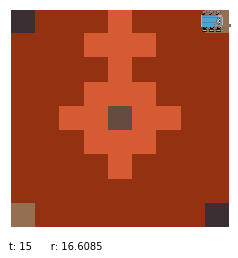

[109.3185664  109.60370074 112.93555786 111.59687526 111.98620463]
2
[0.01569331 0.02087117 0.5841899  0.15316925 0.22607637]
(8, 0) b'1'
(8, 8) b'2'


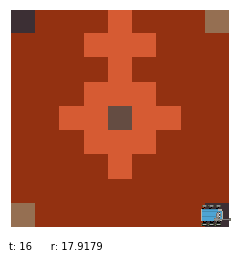

[109.05025183 111.66306274 111.68096027 109.03881457 111.6704307 ]
2
[0.02312259 0.31533047 0.32102491 0.02285964 0.31766239]
(8, 8) b'2'
(0, 8) b'1'


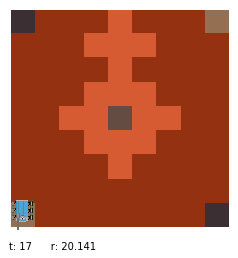

[111.59900639 112.93956966 109.63792628 109.33962724 112.01468796]
1
[0.15193596 0.58057699 0.02137836 0.01586444 0.23024425]
(0, 8) b'1'
(1, 8) b'F'


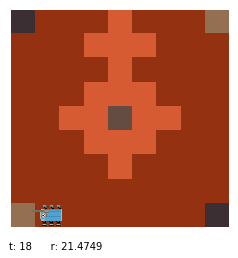

[111.31438702 110.20543411 106.85095188 107.10567555 109.21908056]
0
[0.67598399 0.22300997 0.00778917 0.01004885 0.08316802]
(1, 8) b'F'
(0, 8) b'1'


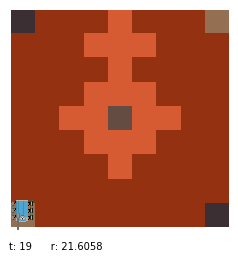

[111.59900639 112.93956966 109.63792628 109.33962724 112.01468796]
1
[0.15193596 0.58057699 0.02137836 0.01586444 0.23024425]
(0, 8) b'1'
(0, 0) b'2'


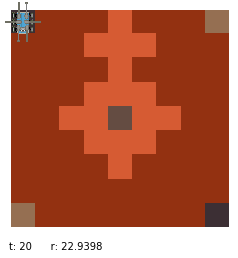

[111.83597674 110.60802766 110.60743895 111.85542407 113.56327317]
4
[0.12149672 0.0355855  0.03556455 0.12388263 0.68347061]
(0, 0) b'2'
(0, 0) b'2'


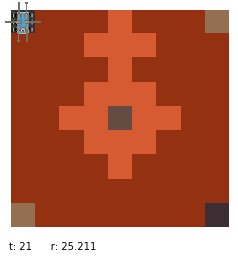

[111.83597674 110.60802766 110.60743895 111.85542407 113.56327317]
4
[0.12149672 0.0355855  0.03556455 0.12388263 0.68347061]
(0, 0) b'2'
(0, 0) b'2'


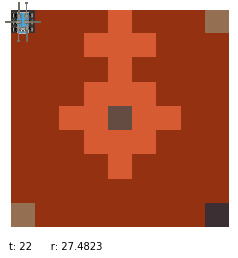

[111.83597674 110.60802766 110.60743895 111.85542407 113.56327317]
4
[0.12149672 0.0355855  0.03556455 0.12388263 0.68347061]
(0, 0) b'2'
(0, 0) b'2'


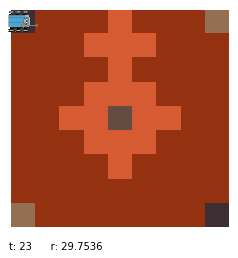

[111.83597674 110.60802766 110.60743895 111.85542407 113.56327317]
2
[0.12149672 0.0355855  0.03556455 0.12388263 0.68347061]
(0, 0) b'2'
(1, 0) b'F'


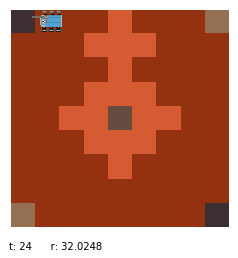

[112.5634704  108.43148747 107.69372922 109.47920143 110.45053238]
0
[0.84007343 0.01348403 0.00644786 0.03844468 0.10155   ]
(1, 0) b'F'
(0, 0) b'2'


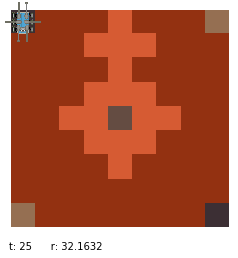

[111.83597674 110.60802766 110.60743895 111.85542407 113.56327317]
4
[0.12149672 0.0355855  0.03556455 0.12388263 0.68347061]
(0, 0) b'2'
(0, 0) b'2'


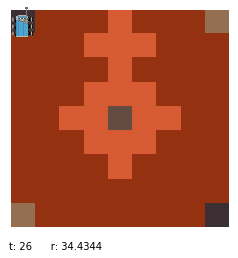

[111.83597674 110.60802766 110.60743895 111.85542407 113.56327317]
3
[0.12149672 0.0355855  0.03556455 0.12388263 0.68347061]
(0, 0) b'2'
(0, 8) b'1'


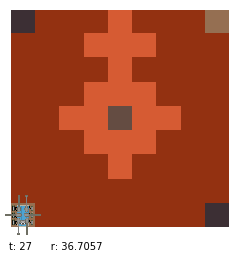

[111.59900639 112.93956966 109.63792628 109.33962724 112.01468796]
4
[0.15193596 0.58057699 0.02137836 0.01586444 0.23024425]
(0, 8) b'1'
(0, 8) b'1'


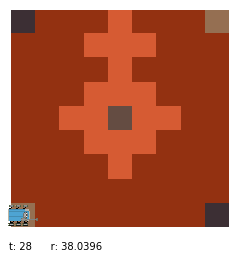

[111.59900639 112.93956966 109.63792628 109.33962724 112.01468796]
2
[0.15193596 0.58057699 0.02137836 0.01586444 0.23024425]
(0, 8) b'1'
(1, 8) b'F'


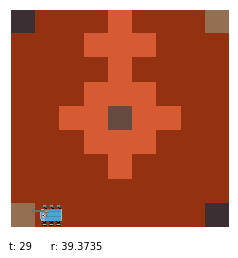

[111.31438702 110.20543411 106.85095188 107.10567555 109.21908056]
0
[0.67598399 0.22300997 0.00778917 0.01004885 0.08316802]
(1, 8) b'F'
(0, 8) b'1'


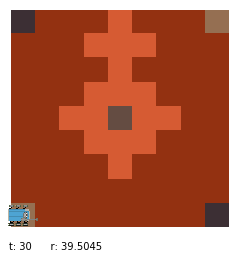

[111.59900639 112.93956966 109.63792628 109.33962724 112.01468796]
2
[0.15193596 0.58057699 0.02137836 0.01586444 0.23024425]
(0, 8) b'1'
(1, 8) b'F'


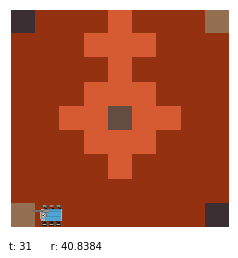

[111.31438702 110.20543411 106.85095188 107.10567555 109.21908056]
0
[0.67598399 0.22300997 0.00778917 0.01004885 0.08316802]
(1, 8) b'F'
(1, 0) b'F'


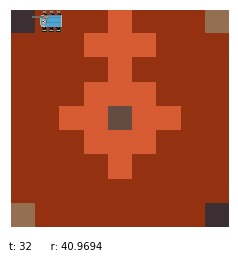

[112.5634704  108.43148747 107.69372922 109.47920143 110.45053238]
0
[0.84007343 0.01348403 0.00644786 0.03844468 0.10155   ]
(1, 0) b'F'
(0, 0) b'2'


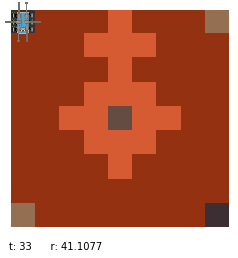

[111.83597674 110.60802766 110.60743895 111.85542407 113.56327317]
4
[0.12149672 0.0355855  0.03556455 0.12388263 0.68347061]
(0, 0) b'2'
(0, 0) b'2'


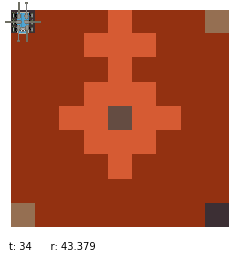

[111.83597674 110.60802766 110.60743895 111.85542407 113.56327317]
4
[0.12149672 0.0355855  0.03556455 0.12388263 0.68347061]
(0, 0) b'2'
(0, 0) b'2'


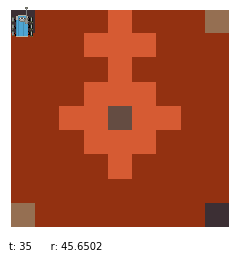

[111.83597674 110.60802766 110.60743895 111.85542407 113.56327317]
3
[0.12149672 0.0355855  0.03556455 0.12388263 0.68347061]
(0, 0) b'2'
(0, 8) b'1'


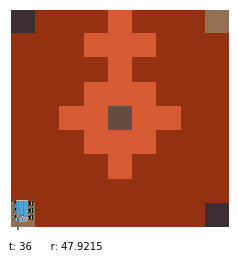

[111.59900639 112.93956966 109.63792628 109.33962724 112.01468796]
1
[0.15193596 0.58057699 0.02137836 0.01586444 0.23024425]
(0, 8) b'1'
(0, 0) b'2'


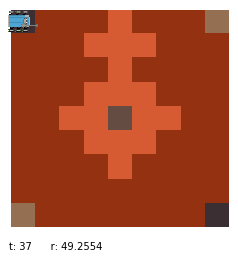

[111.83597674 110.60802766 110.60743895 111.85542407 113.56327317]
2
[0.12149672 0.0355855  0.03556455 0.12388263 0.68347061]
(0, 0) b'2'
(1, 0) b'F'


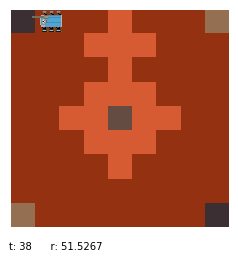

[112.5634704  108.43148747 107.69372922 109.47920143 110.45053238]
0
[0.84007343 0.01348403 0.00644786 0.03844468 0.10155   ]
(1, 0) b'F'
(0, 0) b'2'


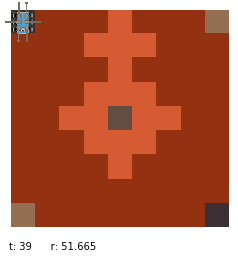

[111.83597674 110.60802766 110.60743895 111.85542407 113.56327317]
4
[0.12149672 0.0355855  0.03556455 0.12388263 0.68347061]
(0, 0) b'2'
(0, 0) b'2'


In [19]:
Q = tabsoftq_learn_Qs(mdp)
plot_mars(mdp,tabsoftq_gen_pol(Q),Qs=Q)


In [20]:
# print(mdp.feature_map)

# Inverse Dynamics Learning

In [21]:
def transition_grad(adt, tps):
    a,d,t = adt
    grad_theta_t = np.zeros(tps.shape)
    grad_theta_t[a,d,t] += 1
    grad_theta_t[a,:,t] -= tps[a,:,t]
    return grad_theta_t


In [22]:
def eval_pol_likelihood(Q, sas_obs, verbose=False):
    ll = 0.0
    for obs in sas_obs:
        s,a,sprime = obs
        l = np.log(softmax(Q[s])[a])
        ll += l
    return ll

def eval_trans_likelihood(Tps, adt_obs, verbose=False):
    ll = 0.0
    for obs in adt_obs:
        a,d,t, = obs
        l = np.log(Tps[a,d,t])
        ll += l
    return ll

def eval_trans_likelihood_and_grad(T_thetas, adt_obs):
    Tps = softmax(T_thetas,axis=1)
    dT = sum([transition_grad(adt,Tps) for adt in adt_obs]).reshape(T_thetas.shape) / len(adt_obs)
    ll = eval_trans_likelihood(Tps, adt_obs)
    return ll, dT

def eval_demo_log_likelihood(sas_obs, adt_obs, T_thetas, Q):
    Tps = softmax(T_thetas,axis=1)
    p_ll = eval_pol_likelihood(Q, sas_obs)
    t_ll = eval_trans_likelihood(Tps, adt_obs)
    return p_ll, t_ll
        

In [23]:
def eval_T_pol_likelihood_and_grad(T_thetas, R, sas_obs, Q_inits=None, verbose=False):
    s = [obs[0] for obs in sas_obs]
    a = [obs[1] for obs in sas_obs]
    Tps = softmax(T_thetas,axis=1)
    T = mdp.adt_trans_to_sas_trans(Tps)
    Q = tabsoftq_iter(R, T, Q_init=Q_inits, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose,
                      ftol=tabsoftq_iter_ftol)
    dT = tabsoftq_T_grad_iter(T_thetas, Q, R, T=T, maxiter=tabsoftq_grad_iter_maxiter,
        verbose=tabsoftq_grad_iter_verbose, ftol=tabsoftq_grad_iter_ftol)
    # Sum instead of mean because sparse results
    if verbose:
        for obs in sas_obs:
            print(obs)
            print(dT[obs[0],obs[1]].reshape(T_thetas.shape))
    dT = np.sum(dT[s,a], axis=0).reshape(T_thetas.shape) / len(sas_obs)
    ll = eval_pol_likelihood(Q, sas_obs)
    return ll, dT, Q


# Simultaneous Estimation of Rewards and Dynamics

In [24]:
def tabsoftq_TR_grad_iter(T_thetas, feat_map, R,  Q, T=None, maxiter=1000, verbose=True,
                       learning_rate=1, G_init=None, ftol=0):
    
    T_theta_dim = T_thetas.shape[0] * T_thetas.shape[1] * T_thetas.shape[2]
    D = T_thetas.shape[1]
    
    R_theta_dim = feat_map.shape[1]
    
    P_broad = tabsoftq_gen_pol_probs(Q).reshape((nS, nA, 1))
    Tps = softmax(T_thetas,axis=1)
    
    if T is None:
        T = mdp.adt_trans_to_sas_trans(Tps)
        
    V = (alpha) * logsumexp(Q * (1 / alpha), axis=1)
    
    R_grad = T.dot(feat_map)
    
    GR = np.zeros((nS, nA, R_theta_dim)) if G_init is None else G_init[0]
    prevGR = copy(GR)
    
    T_grad = np.zeros((nS,nA,T_theta_dim))
    for s in range(nS):
        t = mdp.get_tile_type(s)
        for a in range(nA):
            P_at = Tps[a,:,t]
            V_t = np.array([V[mdp.sd_to_sprime(s,d)] for d in range(D)])
            R_t = np.array([R[mdp.sd_to_sprime(s,d)] for d in range(D)])
            VR_t = R_t + gamma * V_t 
            D_probs = np.stack([P_at for _ in range(D)])
            grad_at = np.dot((np.eye(D) - D_probs), VR_t)
            grad_at = np.dot(np.diag(P_at),grad_at)
            filler = np.zeros(T_thetas.shape)
            filler[a,:,t] = grad_at
            filler = filler.flatten()
            T_grad[s,a] = filler
              
    GT = T_grad if G_init is None else G_init[1]
    T_broad = T.reshape((nS, nA, nS, 1))
    prevGT = copy(GT)
    
    if verbose:
        diffs = []
        
    for iter_idx in range(maxiter):
        # Reward Param gradient iteration
        expGR = np.sum(P_broad * GR, axis=1)
        expGR_broad = expGR.reshape((1, 1, nS, R_theta_dim))
        GR = R_grad + gamma * np.sum(T_broad * expGR_broad, axis=2)
        GR = (1 - learning_rate) * prevGR + learning_rate * GR
        
        
        # Transition Param grad iter
        expGT = np.sum(P_broad * GT, axis=1)
        expGT_broad = expGT.reshape((1, 1, nS, T_theta_dim))
        GT = gamma * T_grad
        t_expGT = np.sum(T_broad * expGT_broad, axis=2)
        GT += gamma * t_expGT
        GT = (1 - learning_rate) * prevGT + learning_rate * GT
    
        diff = np.mean((GR - prevGR)**2)/(np.std(GR)**2) + np.mean((GT - prevGT)**2)/(np.std(GT)**2)
        if verbose:
            diffs.append(diff)
        if diff < ftol:
            break
        prevGR = copy(GR)
        prevGT = copy(GT)
  
    if verbose:
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Squared Bellman Error')
        plt.title('Soft Q Gradient Iteration')
        plt.plot(diffs)
        plt.yscale('log')
        plt.show()
  
    expGR = np.sum(P_broad * GR, axis=1)
    expGR_broad = expGR.reshape((nS, 1, R_theta_dim))
    expGT = np.sum(P_broad * GT, axis=1)
    expGT_broad = expGT.reshape((nS, 1, T_theta_dim))
    return (GR - expGR_broad), (GT - expGT_broad)

In [25]:
def eval_TR_pol_likelihood_and_grad(T_thetas, R, feat_map, sas_obs, Q_inits=None, verbose=False):
    s = [obs[0] for obs in sas_obs]
    a = [obs[1] for obs in sas_obs]
    Tps = softmax(T_thetas,axis=1)
    T = mdp.adt_trans_to_sas_trans(Tps)
    Q = tabsoftq_iter(R, T, Q_init=Q_inits if Q_inits is not None else None, 
        maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)
    dR, dT = tabsoftq_TR_grad_iter(T_thetas, feat_map, R, Q, T=T,
        maxiter=tabsoftq_grad_iter_maxiter, verbose=tabsoftq_grad_iter_verbose, ftol=tabsoftq_grad_iter_ftol)
    if verbose:
        for obs in sas_obs:
            print(obs)
            print(dT[obs[0],obs[1]].reshape(T_thetas.shape))
    dR = np.sum(dR[s,a], axis=0).reshape(feat_map.shape[1]) / len(sas_obs)
    dT = np.sum(dT[s,a], axis=0).reshape(T_thetas.shape) / len(sas_obs)
    ll = eval_pol_likelihood(Q, sas_obs)
    return ll, dT, dR, Q

# IDL & SERD Experiments

In [26]:
tabsoftq_iter_ftol = 1e-32
tabsoftq_iter_maxiter = 5000
tabsoftq_iter_verbose = False
tabsoftq_grad_iter_ftol = 1e-10
tabsoftq_grad_iter_maxiter = 5000
tabsoftq_grad_iter_verbose = False
batch_size = 200
n_demos = 80
demo_time_steps = 40

In [27]:
def clean_demos(sas_obs):
    demo_example_idxes = list(range(len(sas_obs)))
    unique_stays = set([])
    for i,sas in enumerate(sas_obs):
        sas = tuple(sas)
        if sas[1] == 4:
            if sas in unique_stays:
                demo_example_idxes.remove(i)
            else:
                unique_stays.add(sas)
    return demo_example_idxes

def sample_batch(size, ids, sas_obs, adt_obs):
    idxes = random.sample(ids, size)
    return sas_obs[idxes], adt_obs[idxes]

In [28]:
def T_estimate(adt_obs):
    stability = 1e-5
    T_thetas = np.zeros(T_theta_shape)
    T_counts = np.zeros(T_theta_shape) + stability
    for a,d,t in adt_obs:
        T_counts[a,d,t] += 1
    for a in range(T_theta_shape[0]):
        for t in range(T_theta_shape[2]):
            z = np.sum(T_counts[a,:,t])
            for d in range(T_theta_shape[1]):
                if z == T_counts.shape[1] * stability:
                    T_thetas[a,d,t] = 0
                else:
                    T_thetas[a,d,t] = np.log(T_counts[a,d,t]) - np.log(z)
    return T_thetas

def test_T_likelihood(Tps, sas_obs, adt_obs):
    T = mdp.adt_trans_to_sas_trans(Tps)
    R = mdp.rewards
    Q = tabsoftq_iter(R, T, Q_init=None, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)
    pl = eval_pol_likelihood(Q, sas_obs, verbose=True)
    tl = eval_trans_likelihood(Tps, adt_obs, verbose=True)
    print([s for s in range(nS) if mdp.get_tile_type(s)==1])
    print(Q[[s for s in range(nS) if mdp.get_tile_type(s)==1]])
    print(pl, tl)
    return pl + tl

def true_trans_loss(tps):
    tps = mdp.adt_trans_to_sas_trans(tps)
    true_tps = mdp.get_transition_matrix()
    return np.linalg.norm(true_tps-tps)/nA

In [29]:
exQs = tabsoftq_learn_Qs(mdp)
demos = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs), n_demos, demo_time_steps)
sas_obs, adt_obs = vectorize_rollouts(demos)

In [30]:
# Ensure bad areas have not been visited in exes
while len(set([adt[2] for adt in adt_obs])) > 1:
    demos = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs), n_demos, demo_time_steps)
    sas_obs, adt_obs = vectorize_rollouts(demos)

In [31]:
# Clean training set to have greater density of interesting transitions
# print(len(sas_obs))
# demo_example_idxes = clean_demos(sas_obs)
# print(len(demo_example_idxes))
demo_example_idxes = list(range(len(sas_obs)))


In [32]:
random.shuffle(demo_example_idxes)
n_train_demo_examples = int(0.9 * len(demo_example_idxes))
train_demo_example_idxes = demo_example_idxes[:n_train_demo_examples]
val_demo_example_idxes = demo_example_idxes[n_train_demo_examples:]
val_sas_obs = sas_obs[val_demo_example_idxes]
val_adt_obs = adt_obs[val_demo_example_idxes]

## IDL Only

In [33]:
idl_train_logs = {
  'train_likelihoods': [],
  'val_likelihoods': [],
  'tp_lls': [],
  'tt_lls': [],
  'vp_lls': [],
  'vt_lls': [],
  'true_trans_loss': []
}

In [34]:
maxiter = 500
learning_rate = 0.25

In [35]:
Ti_thetas = T_estimate(adt_obs[train_demo_example_idxes])
Qi, Ri = None, mdp.rewards

In [36]:
%%prun -s cumulative

while len(idl_train_logs['tt_lls']) < maxiter:
    try:
        batch_demo_sas, batch_demo_adt = sample_batch(batch_size, train_demo_example_idxes, sas_obs, adt_obs)
        #Should we initialize Qs or nah?
        tp_ll, dT_pol, Qi = eval_T_pol_likelihood_and_grad(Ti_thetas, Ri, batch_demo_sas, Q_inits=Qi, verbose=False)
        tt_ll, dT_trans = eval_trans_likelihood_and_grad(Ti_thetas, batch_demo_adt)
        train_likelihood = tp_ll + tt_ll
        vp_ll, vt_ll = eval_demo_log_likelihood(val_sas_obs, val_adt_obs, Ti_thetas, Qi)
        val_likelihood = vp_ll + vt_ll
        ttd = true_trans_loss(softmax(Ti_thetas))
        Ti_thetas += learning_rate * (dT_trans + dT_pol)

        print('%d %f %f %f %f' % (len(idl_train_logs['tt_lls']), vp_ll, vt_ll, vp_ll + vt_ll, ttd))
        idl_train_logs['train_likelihoods'].append(train_likelihood)
        idl_train_logs['val_likelihoods'].append(val_likelihood)
        idl_train_logs['tp_lls'].append(tp_ll)
        idl_train_logs['tt_lls'].append(tt_ll)
        idl_train_logs['vp_lls'].append(vp_ll)
        idl_train_logs['vt_lls'].append(vt_ll)
        idl_train_logs['true_trans_loss'].append(ttd)
    except KeyboardInterrupt:
        break

0 -770.597141 -135.268604 -905.865745 1.601974
1 -767.425404 -135.207165 -902.632569 1.599373
2 -757.258425 -135.162130 -892.420555 1.596883
3 -741.957151 -135.135722 -877.092873 1.594650
4 -743.298624 -135.117166 -878.415790 1.592136
5 -728.214043 -135.104844 -863.318887 1.590084
6 -710.549248 -135.117667 -845.666915 1.588018
7 -706.431002 -135.112392 -841.543394 1.585723
8 -707.302963 -135.140179 -842.443141 1.583250
9 -686.365786 -135.177460 -821.543246 1.582104
10 -685.452820 -135.191891 -820.644711 1.579833
 

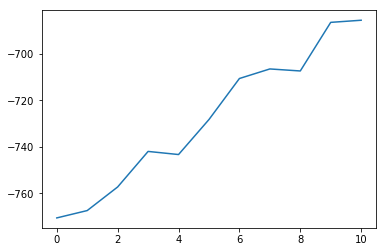

In [37]:
plt.plot(idl_train_logs['vp_lls'])

In [ ]:
plt.plot(idl_train_logs['vt_lls'])

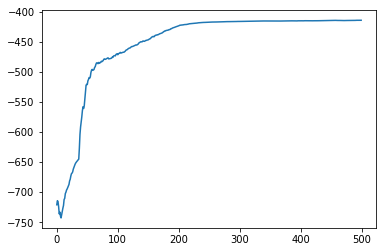

In [40]:
plt.plot(idl_train_logs['val_likelihoods'])

In [41]:
print(Qi[[s for s in range(nS) if mdp.get_tile_type(s)==1]])

[[101.54015144 101.54015144 101.54015144 101.54015144 101.54015144]
 [104.34698316 104.34698316 104.34698316 104.34698316 104.34698316]
 [100.85731552 100.85731552 100.85731552 100.85731552 100.85731552]
 [103.85379911 103.85379911 103.85379911 103.85379911 103.85379911]
 [112.38742295 112.38742295 112.38742295 112.38742295 112.38742295]
 [113.94907389 113.94907389 113.94907389 113.94907389 113.94907389]
 [138.89723303 138.89723303 138.89723303 138.89723303 138.89723303]
 [112.70972303 112.70972303 112.70972303 112.70972303 112.70972303]
 [105.76105015 105.76105015 105.76105015 105.76105015 105.76105015]
 [121.41350809 121.41350809 121.41350809 121.41350809 121.41350809]
 [119.87347153 119.87347153 119.87347153 119.87347153 119.87347153]
 [104.41979981 104.41979981 104.41979981 104.41979981 104.41979981]
 [108.60869934 108.60869934 108.60869934 108.60869934 108.60869934]
 [124.06307079 124.06307079 124.06307079 124.06307079 124.06307079]
 [107.51253442 107.51253442 107.51253442 107.512

/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


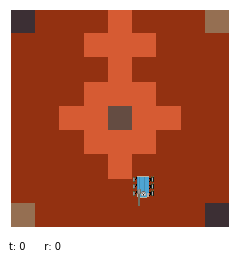

(5, 7) b'S'
(5, 8) b'F'


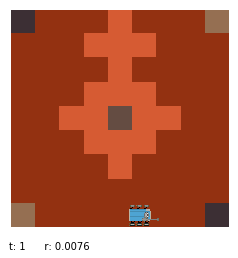

(5, 8) b'F'
(5, 0) b'F'


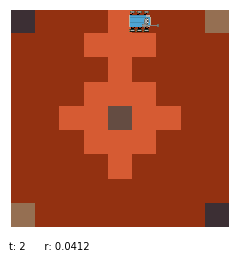

(5, 0) b'F'
(6, 0) b'F'


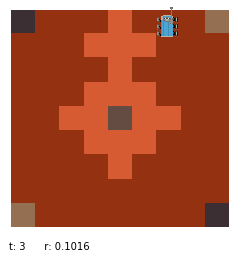

(6, 0) b'F'
(6, 8) b'F'


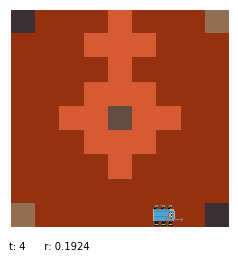

(6, 8) b'F'
(6, 0) b'F'


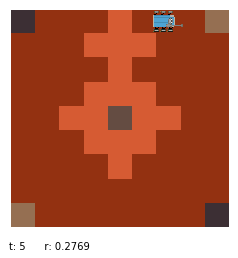

(6, 0) b'F'
(7, 0) b'F'


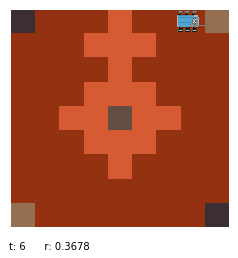

(7, 0) b'F'
(7, 8) b'F'


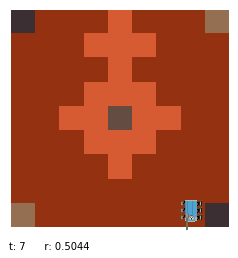

(7, 8) b'F'
(6, 8) b'F'


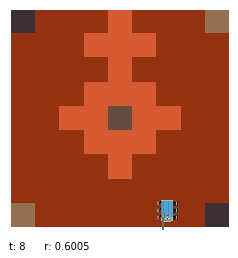

(6, 8) b'F'
(6, 0) b'F'


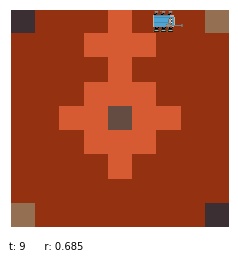

(6, 0) b'F'
(7, 0) b'F'


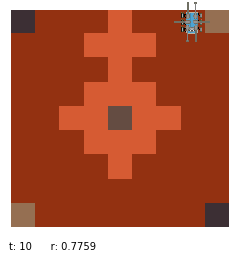

(7, 0) b'F'
(7, 0) b'F'


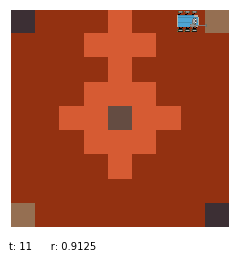

(7, 0) b'F'
(7, 1) b'F'


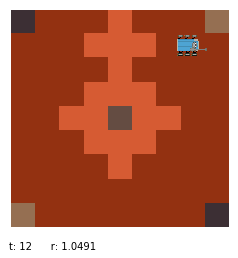

(7, 1) b'F'
(8, 1) b'F'


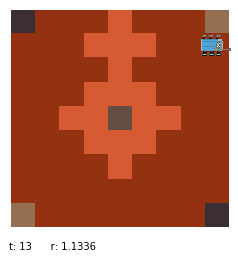

(8, 1) b'F'
(0, 1) b'F'


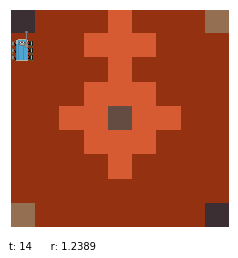

(0, 1) b'F'
(0, 0) b'2'


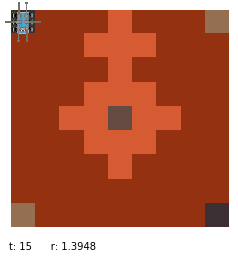

(0, 0) b'2'
(0, 0) b'2'


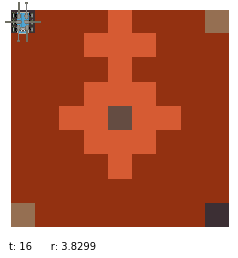

(0, 0) b'2'
(0, 0) b'2'


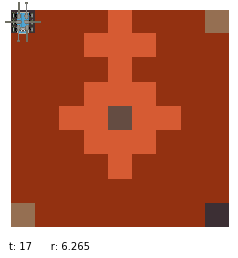

(0, 0) b'2'
(0, 0) b'2'


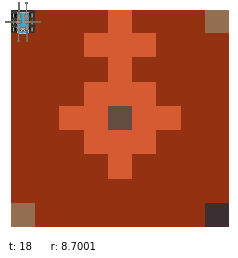

(0, 0) b'2'
(0, 0) b'2'


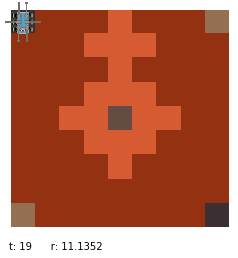

(0, 0) b'2'
(0, 0) b'2'


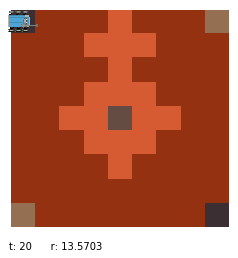

(0, 0) b'2'
(1, 0) b'F'


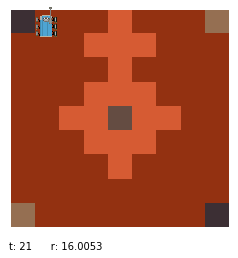

(1, 0) b'F'
(1, 8) b'F'


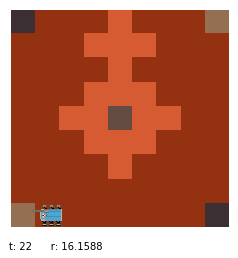

(1, 8) b'F'
(0, 8) b'1'


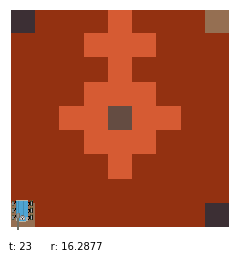

(0, 8) b'1'
(0, 0) b'2'


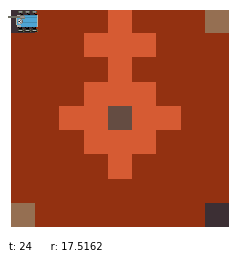

(0, 0) b'2'
(0, 1) b'F'


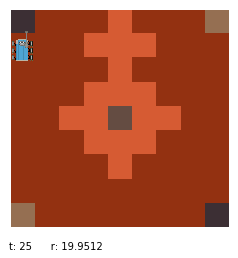

(0, 1) b'F'
(1, 1) b'F'


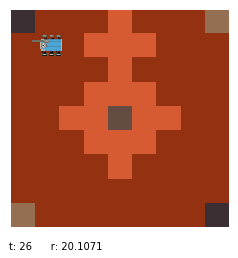

(1, 1) b'F'
(0, 1) b'F'


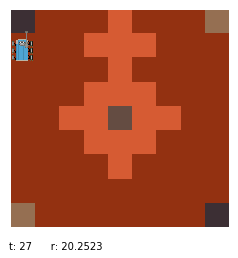

(0, 1) b'F'
(0, 0) b'2'


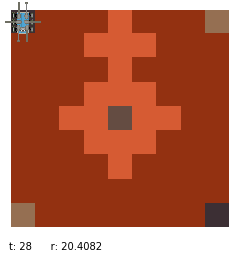

(0, 0) b'2'
(0, 0) b'2'


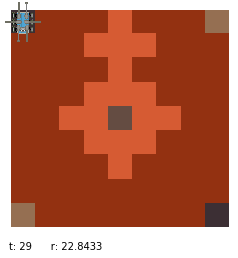

(0, 0) b'2'
(0, 0) b'2'


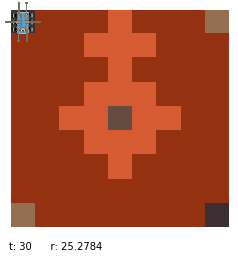

(0, 0) b'2'
(0, 0) b'2'


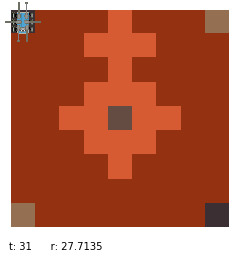

(0, 0) b'2'
(0, 0) b'2'


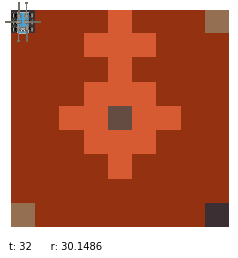

(0, 0) b'2'
(0, 0) b'2'


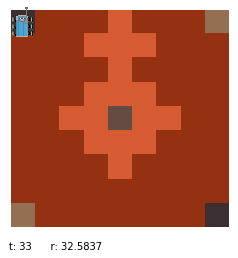

(0, 0) b'2'
(0, 8) b'1'


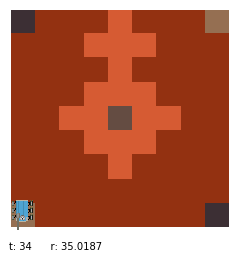

(0, 8) b'1'
(0, 0) b'2'


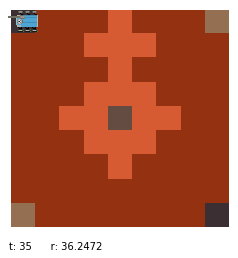

(0, 0) b'2'
(8, 0) b'1'


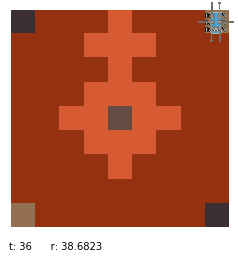

(8, 0) b'1'
(8, 0) b'1'


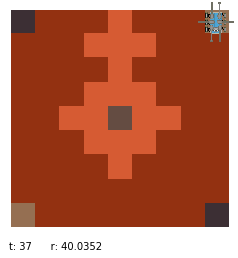

(8, 0) b'1'
(8, 0) b'1'


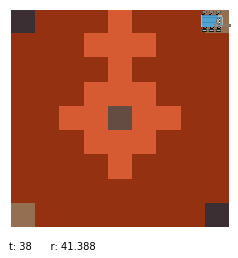

(8, 0) b'1'
(0, 0) b'2'


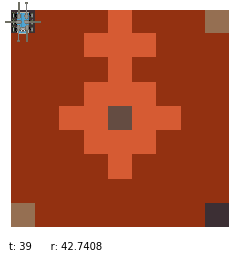

(0, 0) b'2'
(0, 0) b'2'
[[[0.75661909 0.0688394 ]
  [0.13649036 0.13363353]
  [0.00000003 0.07129067]
  [0.10689049 0.08954699]
  [0.00000003 0.63668941]]

 [[0.13372381 0.0688394 ]
  [0.78646038 0.13363353]
  [0.07981577 0.07129067]
  [0.00000002 0.08954699]
  [0.00000002 0.63668941]]

 [[0.00000002 0.0688394 ]
  [0.09075466 0.13363353]
  [0.80415278 0.07129067]
  [0.10509252 0.08954699]
  [0.00000002 0.63668941]]

 [[0.10123187 0.0688394 ]
  [0.00000003 0.13363353]
  [0.10891644 0.07129067]
  [0.78985163 0.08954699]
  [0.00000003 0.63668941]]

 [[0.00000001 0.0688394 ]
  [0.00000001 0.13363353]
  [0.00000001 0.07129067]
  [0.00000001 0.08954699]
  [0.99999997 0.63668941]]]


In [42]:
plot_mars(mdp,tabsoftq_gen_pol(Qi))
print(softmax(Ti_thetas))

In [43]:
Qi.shape

(81, 5)

In [44]:
softmax(Ti_thetas).transpose((2,0,1))

array([[[0.75661909, 0.13649036, 0.00000003, 0.10689049, 0.00000003],
        [0.13372381, 0.78646038, 0.07981577, 0.00000002, 0.00000002],
        [0.00000002, 0.09075466, 0.80415278, 0.10509252, 0.00000002],
        [0.10123187, 0.00000003, 0.10891644, 0.78985163, 0.00000003],
        [0.00000001, 0.00000001, 0.00000001, 0.00000001, 0.99999997]],

       [[0.0688394 , 0.13363353, 0.07129067, 0.08954699, 0.63668941],
        [0.0688394 , 0.13363353, 0.07129067, 0.08954699, 0.63668941],
        [0.0688394 , 0.13363353, 0.07129067, 0.08954699, 0.63668941],
        [0.0688394 , 0.13363353, 0.07129067, 0.08954699, 0.63668941],
        [0.0688394 , 0.13363353, 0.07129067, 0.08954699, 0.63668941]]])

In [45]:
tabsoftq_gen_pol_probs(Qi)

array([[0.10104044, 0.02967142, 0.02354334, 0.0928144 , 0.7529304 ],
       [0.86261872, 0.01241768, 0.00363208, 0.03071149, 0.09062003],
       [0.85221794, 0.01724065, 0.00219019, 0.03797996, 0.09037126],
       [0.84752876, 0.00013253, 0.00000822, 0.05100836, 0.10132214],
       [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.00001073, 0.00004741, 0.85474071, 0.04899126, 0.09620989],
       [0.00391063, 0.01216101, 0.83890751, 0.0546169 , 0.09040395],
       [0.00553416, 0.00958124, 0.84045252, 0.05536262, 0.08906947],
       [0.01219077, 0.01507324, 0.63905726, 0.11411162, 0.21956711],
       [0.02967398, 0.00444007, 0.00848537, 0.86656804, 0.09083254],
       [0.47039008, 0.00656876, 0.00488825, 0.46627193, 0.05188098],
       [0.69226531, 0.00733032, 0.00002533, 0.22047608, 0.07990296],
       [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.2       , 0.2       , 0.

In [46]:
print(softmax(Ti_thetas)) # - softmax(T_estimate(adt_obs[train_demo_example_idxes])))

[[[0.75661909 0.0688394 ]
  [0.13649036 0.13363353]
  [0.00000003 0.07129067]
  [0.10689049 0.08954699]
  [0.00000003 0.63668941]]

 [[0.13372381 0.0688394 ]
  [0.78646038 0.13363353]
  [0.07981577 0.07129067]
  [0.00000002 0.08954699]
  [0.00000002 0.63668941]]

 [[0.00000002 0.0688394 ]
  [0.09075466 0.13363353]
  [0.80415278 0.07129067]
  [0.10509252 0.08954699]
  [0.00000002 0.63668941]]

 [[0.10123187 0.0688394 ]
  [0.00000003 0.13363353]
  [0.10891644 0.07129067]
  [0.78985163 0.08954699]
  [0.00000003 0.63668941]]

 [[0.00000001 0.0688394 ]
  [0.00000001 0.13363353]
  [0.00000001 0.07129067]
  [0.00000001 0.08954699]
  [0.99999997 0.63668941]]]


In [47]:
test_T_likelihood(softmax(Ti_thetas), val_sas_obs, val_adt_obs)

[4, 12, 13, 14, 22, 30, 31, 32, 38, 39, 41, 42, 48, 49, 50, 58]
[[101.5319503  101.5319503  101.5319503  101.5319503  101.5319503 ]
 [104.32212227 104.32212227 104.32212227 104.32212227 104.32212227]
 [100.82883457 100.82883457 100.82883457 100.82883457 100.82883457]
 [103.83915477 103.83915477 103.83915477 103.83915477 103.83915477]
 [112.34933312 112.34933312 112.34933312 112.34933312 112.34933312]
 [113.92571895 113.92571895 113.92571895 113.92571895 113.92571895]
 [138.86267532 138.86267532 138.86267532 138.86267532 138.86267532]
 [112.67120337 112.67120337 112.67120337 112.67120337 112.67120337]
 [105.74836473 105.74836473 105.74836473 105.74836473 105.74836473]
 [121.40355956 121.40355956 121.40355956 121.40355956 121.40355956]
 [119.84667755 119.84667755 119.84667755 119.84667755 119.84667755]
 [104.40329268 104.40329268 104.40329268 104.40329268 104.40329268]
 [108.60629339 108.60629339 108.60629339 108.60629339 108.60629339]
 [124.06720135 124.06720135 124.06720135 124.0672013

-414.47264734729936

In [48]:
test_T_likelihood(softmax(T_estimate(adt_obs[train_demo_example_idxes])), val_sas_obs, val_adt_obs)

[4, 12, 13, 14, 22, 30, 31, 32, 38, 39, 41, 42, 48, 49, 50, 58]
[[122.86522304 122.86522304 122.86522304 122.86522304 122.86522304]
 [124.80733249 124.80733249 124.80733249 124.80733249 124.80733249]
 [123.12469914 123.12469914 123.12469914 123.12469914 123.12469914]
 [124.89695505 124.89695505 124.89695505 124.89695505 124.89695505]
 [132.49222608 132.49222608 132.49222608 132.49222608 132.49222608]
 [139.32810877 139.32810877 139.32810877 139.32810877 139.32810877]
 [150.13220942 150.13220942 150.13220942 150.13220942 150.13220942]
 [139.37411939 139.37411939 139.37411939 139.37411939 139.37411939]
 [135.1140974  135.1140974  135.1140974  135.1140974  135.1140974 ]
 [150.94239012 150.94239012 150.94239012 150.94239012 150.94239012]
 [150.94858512 150.94858512 150.94858512 150.94858512 150.94858512]
 [135.11743031 135.11743031 135.11743031 135.11743031 135.11743031]
 [140.07564239 140.07564239 140.07564239 140.07564239 140.07564239]
 [151.2338851  151.2338851  151.2338851  151.2338851

-721.0887603459812

In [49]:
test_T_likelihood(true_tps, val_sas_obs, val_adt_obs)

[4, 12, 13, 14, 22, 30, 31, 32, 38, 39, 41, 42, 48, 49, 50, 58]
[[0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]]
-286.68

-403.3477650381367

In [50]:
true_trans_loss(softmax(Ti_thetas))

0.7418893741068084

In [51]:
softmax(Ti_thetas)

array([[[0.75661909, 0.0688394 ],
        [0.13649036, 0.13363353],
        [0.00000003, 0.07129067],
        [0.10689049, 0.08954699],
        [0.00000003, 0.63668941]],

       [[0.13372381, 0.0688394 ],
        [0.78646038, 0.13363353],
        [0.07981577, 0.07129067],
        [0.00000002, 0.08954699],
        [0.00000002, 0.63668941]],

       [[0.00000002, 0.0688394 ],
        [0.09075466, 0.13363353],
        [0.80415278, 0.07129067],
        [0.10509252, 0.08954699],
        [0.00000002, 0.63668941]],

       [[0.10123187, 0.0688394 ],
        [0.00000003, 0.13363353],
        [0.10891644, 0.07129067],
        [0.78985163, 0.08954699],
        [0.00000003, 0.63668941]],

       [[0.00000001, 0.0688394 ],
        [0.00000001, 0.13363353],
        [0.00000001, 0.07129067],
        [0.00000001, 0.08954699],
        [0.99999997, 0.63668941]]])

In [52]:
true_trans_loss(softmax(T_estimate(adt_obs[train_demo_example_idxes])))

1.6020488178872074

In [53]:
softmax(T_estimate(adt_obs[train_demo_example_idxes]))

array([[[0.79436611, 0.2       ],
        [0.10704227, 0.2       ],
        [0.00000003, 0.2       ],
        [0.09859156, 0.2       ],
        [0.00000003, 0.2       ]],

       [[0.13015185, 0.2       ],
        [0.78741859, 0.2       ],
        [0.08242951, 0.2       ],
        [0.00000002, 0.2       ],
        [0.00000002, 0.2       ]],

       [[0.00000002, 0.2       ],
        [0.09586058, 0.2       ],
        [0.79520691, 0.2       ],
        [0.10893247, 0.2       ],
        [0.00000002, 0.2       ]],

       [[0.09438777, 0.2       ],
        [0.00000003, 0.2       ],
        [0.08163267, 0.2       ],
        [0.82397951, 0.2       ],
        [0.00000003, 0.2       ]],

       [[0.00000001, 0.2       ],
        [0.00000001, 0.2       ],
        [0.00000001, 0.2       ],
        [0.00000001, 0.2       ],
        [0.99999997, 0.2       ]]])

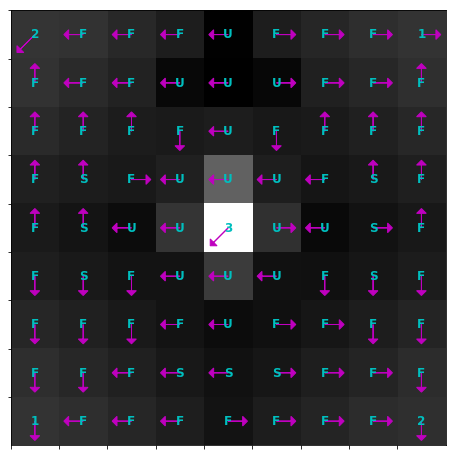

In [54]:
plot_values(mdp, Qi)

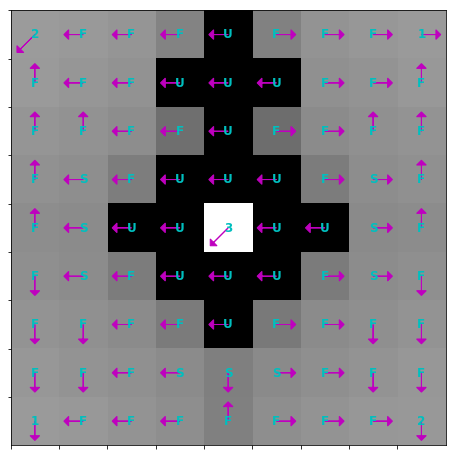

In [55]:
plot_values(mdp, exQs)

## SERD only

In [38]:
serd_train_logs = {
  'train_likelihoods': [],
  'val_likelihoods': [],
  'tp_lls': [],
  'tt_lls': [],
  'vp_lls': [],
  'vt_lls': [],
  'true_trans_loss': []
}

In [39]:
Ts_thetas = T_estimate(adt_obs[train_demo_example_idxes]) #np.log(Tps2+.000000001)
feats = mdp.feature_map
Rs_thetas = np.random.normal(loc=1,scale=0.1,size=feats.shape[1])
Qs = None

In [40]:
maxiter = 300
t_learning_rate = lambda t: 0 if t<20 else 3 - (2 * int(t/(maxiter/2)))
r_learning_rate = lambda t: 2e-1 if t<20 else 1e-1

In [42]:
%%prun -s cumulative

try:
    while len(serd_train_logs['tt_lls']) < maxiter:
        prevQs = Qs.copy() if Qs is not None else None
        t = len(serd_train_logs['tt_lls'])
        batch_demo_sas, batch_demo_adt = sample_batch(batch_size, train_demo_example_idxes, sas_obs, adt_obs)
        Rs = feats.dot(Rs_thetas)
        tp_ll, dT_pol, dR_pol, Qs = eval_TR_pol_likelihood_and_grad(Ts_thetas, Rs, feats, batch_demo_sas, Q_inits=Qs)
        tt_ll, dT_trans = eval_trans_likelihood_and_grad(Ts_thetas, batch_demo_adt)
        train_likelihood = tp_ll + tt_ll
        vp_ll, vt_ll = eval_demo_log_likelihood(val_sas_obs, val_adt_obs, Ts_thetas, Qs)
        val_likelihood = vp_ll + vt_ll
        ttd = true_trans_loss(softmax(Ts_thetas))
        Rs_thetas += r_learning_rate(t) * dR_pol
        Ts_thetas += t_learning_rate(t) * (dT_trans + dT_pol)

    #     print(dT_trans)
    #     print(dT_pol)
    #     print(softmax(Ts_thetas))
    #     print(dR_pol * r_learning_rate(t))
    #     print(Rs_thetas)
    #     if prevQs is not None:
    #         print("Q_diff")
    #         print(np.linalg.norm(Qs-prevQs))


        print('%d %f %f %f %f' % (t, vp_ll, vt_ll, vp_ll + vt_ll, ttd))
        serd_train_logs['train_likelihoods'].append(train_likelihood)
        serd_train_logs['val_likelihoods'].append(val_likelihood)
        serd_train_logs['tp_lls'].append(tp_ll)
        serd_train_logs['tt_lls'].append(tt_ll)
        serd_train_logs['vp_lls'].append(vp_ll)
        serd_train_logs['vt_lls'].append(vt_ll)
        serd_train_logs['true_trans_loss'].append(ttd)
except KeyboardInterrupt:
    pass

3 -363.470432 -135.268604 -498.739036 1.601974
4 -357.623280 -135.268604 -492.891884 1.601974
5 -353.479152 -135.268604 -488.747756 1.601974
6 -349.843917 -135.268604 -485.112521 1.601974
 

In [ ]:
print(softmax(Ts_thetas))

In [ ]:
print(Rs_thetas)

In [ ]:
true_trans_loss(softmax(Ts_thetas))

In [ ]:
plt.plot(serd_train_logs['vp_lls'][:250])
plt.plot(idl_train_logs['vp_lls'][:250])

In [ ]:
plt.plot(serd_train_logs['vt_lls'][:250])
plt.plot(idl_train_logs['vt_lls'][:250])

In [ ]:
plt.plot(serd_train_logs['val_likelihoods'], label = "SERD")
plt.plot(idl_train_logs['val_likelihoods'], label = "IDL")
plt.title("Log likelihood of Demonstrations")
plt.xlabel("Iterations of MDCE")
plt.ylabel("Log Likelihood")
plt.legend()

In [ ]:
plt.plot(serd_train_logs['true_trans_loss'], label = "SERD")
plt.plot(idl_train_logs['true_trans_loss'], label = "IDL")
plt.title("Square Error of Learned Transition Parameters")
plt.xlabel("Iterations of MDCE")
plt.ylabel("Summed Square Error")
plt.legend()

## Comparison Tests

In [ ]:
def demo_stats(mdp, demos):
    demo_rewards = []
    for i in range(len(demos)):
        demo_rewards += [np.array([mdp.rewards[obs[0][2]] for obs in demos[i]])]
#         for j in range(len(demo_rewards[i])):
#             print(demos[i][j][0], demo_rewards[i][j])
    
    discounted_demo_rewards = [np.power(gamma,np.arange(len(dr)))*dr for dr in demo_rewards]
    demo_rewards, discounted_demo_rewards = np.array(demo_rewards), np.array(discounted_demo_rewards)
    data = {"mean episode reward": np.mean(np.sum(demo_rewards, axis=1)),
            "sd episode reward": np.std(np.sum(demo_rewards, axis=1)),
            "mean discounted episode reward": np.mean(np.sum(discounted_demo_rewards, axis=1)),
            "sd discounted episode reward": np.std(np.sum(discounted_demo_rewards, axis=1))}
    return data
    
    

In [ ]:
SERD_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qs), 2000, demo_time_steps)
IDL_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qi), 2000, demo_time_steps)

In [ ]:
print(demo_stats(mdp, SERD_demos))

In [ ]:
print(demo_stats(mdp, IDL_demos))

In [ ]:
plot_values(mdp, Qs)

In [ ]:
plot_values(mdp, Qi)

In [ ]:
print(reward_map[5][0], Qi[2], Q[2])

### Transfer

In [ ]:
tile_map2 = [
        "2FFFFFFF1",
        "FFFFFFFFF",
        "FFFFUFFFF",
        "FFFUUUFSF",
        "FFUU3UUFF",
        "FSFUUUFSF",
        "FSFFUFFSF",
        "FFFSSSFFF",
        "1FFFFFFF2"
    ]
reward_map2, texture_map2 = build_reward_map(tile_map2, tile_rewards, goal_tile_rewards, tile_reward_modifier)
# reward_normalizer2 = (1-gamma)/(np.max(reward_map2))
# reward_map2 *= reward_normalizer2
# time_penalty *= reward_normalizer2
# temperature2 = 1/(reward_normalizer2)
# print(temperature2)
print(reward_map2)
print(texture_map2)

In [ ]:
mdp = MarsExplorerEnv(tile_map2, reward_map2, texture_map2, trans_dict, time_penalty) 
nA = mdp.num_actions
nS = mdp.num_states

In [ ]:

Tips = softmax(Ti_thetas,axis=1)
Ti = mdp.adt_trans_to_sas_trans(Tips)
Ri = mdp.rewards
Qit = tabsoftq_iter(Ri, Ti, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
Tips = softmax(Ti_thetas,axis=1)
Ti = mdp.adt_trans_to_sas_trans(Tips)
Ri = mdp.rewards
Qit = tabsoftq_iter(Ri, Ti, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
Tsps = softmax(Ts_thetas,axis=1)
Ts = mdp.adt_trans_to_sas_trans(Tips)
Rs = mdp.feature_map.dot(Rs_thetas)
Qst = tabsoftq_iter(Rs, Ts, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
IDL_trans_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qit), 1000, demo_time_steps)
SERD_trans_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qst), 1000, demo_time_steps)

In [ ]:
plot_mars(mdp,tabsoftq_gen_pol(Qit),Qs=Qit)

In [ ]:
print(demo_stats(mdp, IDL_trans_demos))

In [ ]:
print(demo_stats(mdp, SERD_trans_demos))

In [ ]:
plot_values(mdp, Qit)

In [ ]:
plot_values(mdp, Qst)

In [ ]:
Qtrue = tabsoftq_learn_Qs(mdp)
plot_values(mdp,Qtrue)